# Surface presence and volumes by oil types

Use [monte_carlo.yaml](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/envs/monte_carlo.yaml) to create an environment for this notebook:
```
 conda env create -f monte_carlo.yaml
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

**Useful information**: 
- this code was developed with `Python 3.6`
- aggregation files were created with [incremental_sums.py](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/aggregation_scripts/Incremental_Sums.py).
- the output from `Incremental_Sums.py` was saved to (and loaded from) `../../analysis_files/aggregated_spills_output/`
- a graphics style template in [../style_templates](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/tree/main/style_templates) was used.

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import os
import matplotlib.ticker as ticker
import matplotlib

# set colormap so it's white (water) and papayawhip (land)
my_cmap = matplotlib.cm.get_cmap('Greens').copy()
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

%matplotlib inline

/var/folders/36/r7rkkw2567v70rmk6z0twn6r0000gp/T/ipykernel_71120/3635275475.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = matplotlib.cm.get_cmap('Greens').copy()


In [2]:
# define directory paths
if os.sys.platform=="darwin": # For Shuga
    graphics_directory = Path(
         '/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/graphics'
    )
    # Aggregated files path
    agg_dir = Path('../../analysis_files/aggregated_spills_output/')
    # graphics style
    plt.style.use(r"../style_templates/MuellerEtAl_matplotlibrc.template")
else:
    # Aggregated files path
    agg_dir = Path('/data/sallen/MIDOSS/aggregated_spills_files/')
    # monte carlo spills file
    spill_dir = Path('/ocean/rmueller/MIDOSS/spill_files_091921/')
    # MEOPAR ASM graphics directory
    graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics')

# Load SalishSeaCast grid 

In [3]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

# Load aggregated results

In [6]:
beach={}
water={}
sfc={}
sfc_presence_diff={}
sfc_presence={}
ma_surface_diff={}
ma_surface={}

eps = 1e-7 # to impose values > 0
cubicmeter_to_ML = 1e-3
smalloils = 113 + 54  # Small spills in 10,000 that didn't meet thresholds but were a part of 10,000 spills

In [8]:
## Load oil types
oil_types = ['akns','bunker','diesel','dilbit','oils']
for oil_type in oil_types:
    print(f'***{oil_type}***')
    
    oil = xr.open_dataset(agg_dir/f'fiftieth_55_{oil_type}.nc')
    
    # geometric mean beached oil
    ma_beach_oil = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0
    )
    beach2d = np.exp(ma_beach_oil)
    
    # geometric mean Deep Oil (depth integrated: $m^3$)
    ma_deep_oil = np.ma.masked_array(
        oil.deep_oil[0]/(oil.deeppresence + eps), oil.deeppresence == 0
    )
    water2d = np.exp(ma_deep_oil)
       
    # Surface Oil Geometric mean thickness ($m^3$)
    ma_surface_oil = np.ma.masked_array(
        oil.surface_oil[0]/(oil.oilpresence + eps), oil.oilpresence == 0
    ) 
    sfc2d = np.exp(ma_surface_oil)
        
    # Surface Oil Presence
    ma_oil_pres = np.ma.masked_array(
        oil.oilpresence, oil.oilpresence == 0
    )
    # Store surface thickness by oil type
    ma_surface[oil_type]=ma_surface_oil    
    # Store surface presence by oil type
    sfc_presence[oil_type]=ma_oil_pres
    
    # create dictionaries used for plotting results
    water[oil_type] = water2d.sum()*cubicmeter_to_ML
    sfc[oil_type] = sfc2d.sum()*cubicmeter_to_ML
    beach[oil_type] = beach2d.sum()*cubicmeter_to_ML

***akns***
***bunker***
***diesel***
***dilbit***
***oils***


# Graphic specifications

In [9]:
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# Plot surface presence by oil types

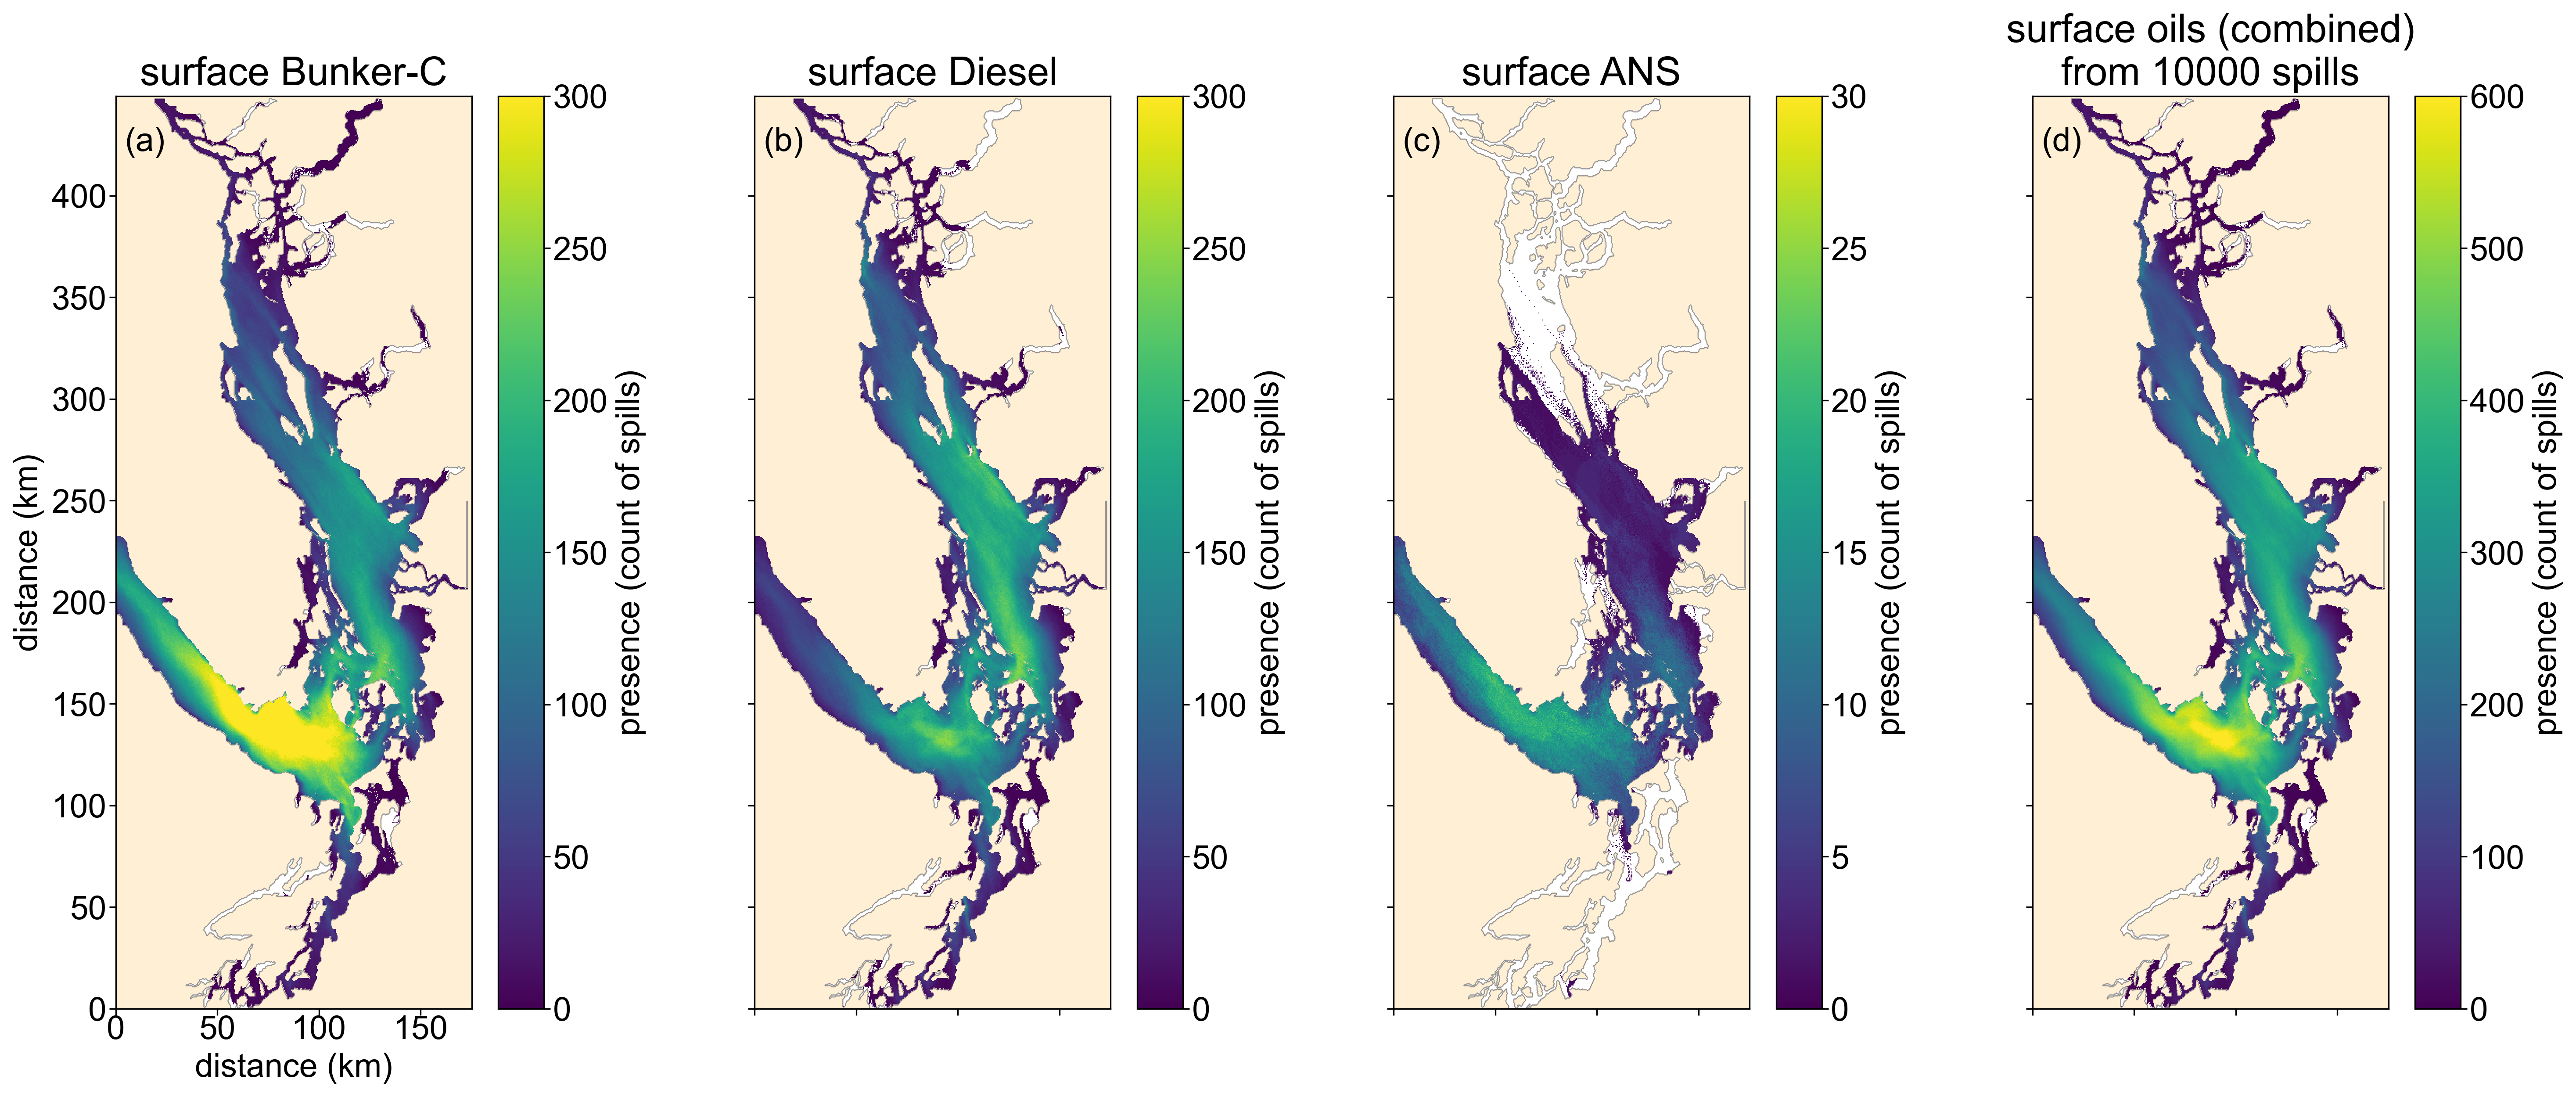

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(24, 9),
    gridspec_kw={'hspace': 0.0})

vmin, vmax = 0.01, 50

for idx,ax in enumerate(axs):
    ax.pcolormesh(tmask[1:, 1:], cmap=my_cmap, vmin=.1, vmax=.8)
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    # add x- and y-labels using
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
 
    
C = axs[0].pcolormesh(sfc_presence['bunker'], vmin=0, vmax=300, zorder=2)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')
axs[0].set_title('surface Bunker-C');  

C = axs[1].pcolormesh(sfc_presence['diesel'],  vmin=0, vmax=300, zorder=2)
cb = fig.colorbar(C, ax=axs[1]);    
cb.set_label('presence (count of spills)')
axs[1].set_title('surface Diesel');   

C = axs[2].pcolormesh(sfc_presence['akns'],  vmin=0, vmax=30, zorder=2)
cb = fig.colorbar(C, ax=axs[2]);    
cb.set_label('presence (count of spills)')
axs[2].set_title('surface ANS');   

C = axs[3].pcolormesh(sfc_presence['oils'], vmin=0, vmax=600, zorder=2)
cb = fig.colorbar(C, ax=axs[3]);    
cb.set_label('presence (count of spills)')
axs[3].set_title(f'surface oils (combined)\nfrom {oil.nofiles.values+smalloils} spills');  

# add subplot labels
subplot_labels=['(a)','(b)','(c)','(d)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig('../../Publications/MIDOSS_MuellerEtAl/graphics/Figure10_surface_presence.png')